In [1]:
BASE = "/kaggle/input/brain-tumor-mri-classification"
TRAIN_DIR = f"{BASE}/Training/Training"
TEST_DIR  = f"{BASE}/Testing/Testing"

!ls -lah "$TRAIN_DIR"
!ls -lah "$TEST_DIR"


total 0
drwxr-xr-x 6 nobody nogroup 0 Nov 12 18:27 .
drwxr-xr-x 3 nobody nogroup 0 Nov 12 18:24 ..
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:25 glioma
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:26 meningioma
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:27 notumor
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:27 pituitary
total 0
drwxr-xr-x 6 nobody nogroup 0 Nov 12 18:24 .
drwxr-xr-x 3 nobody nogroup 0 Nov 12 18:23 ..
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:23 glioma
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:23 meningioma
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:24 notumor
drwxr-xr-x 2 nobody nogroup 0 Nov 12 18:24 pituitary


In [2]:
import os, time, json, random
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import cv2
import joblib
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except:
    pass

from skimage.feature import hog, graycomatrix, graycoprops
from skimage.util import img_as_ubyte

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


from sklearn.experimental import enable_halving_search_cv  

from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import loguniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

try:
    cv2.setNumThreads(0)
except:
    pass

os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

WORK = Path("/kaggle/working")
WORK.mkdir(parents=True, exist_ok=True)


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [3]:
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

def list_images_in_class(root: str, class_name: str) -> List[Path]:
    p = Path(root)/class_name
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts: files.extend(p.rglob(e))
    return sorted(files)

def load_split(root: str, class_names: List[str]) -> Tuple[List[Path], np.ndarray]:
    paths, labels = [], []
    for i,c in enumerate(class_names):
        imgs = list_images_in_class(root, c)
        paths.extend(imgs)
        labels.extend([i]*len(imgs))
    return paths, np.array(labels, dtype=np.int64)


In [4]:
@dataclass
class FeatCfg:
    img_w: int = 224
    img_h: int = 224
    hog_ppc = (16,16)
    hog_cpb = (2,2)
    hog_orient = 9

def to_gray01(bgr: np.ndarray) -> np.ndarray:
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return (g/255.0).astype(np.float32)

def compute_hog(gray01: np.ndarray, cfg: FeatCfg) -> np.ndarray:
    f = hog(gray01, orientations=cfg.hog_orient,
            pixels_per_cell=cfg.hog_ppc, cells_per_block=cfg.hog_cpb,
            transform_sqrt=True, block_norm="L2-Hys", feature_vector=True)
    return f.astype(np.float32)

def compute_glcm(gray01: np.ndarray) -> np.ndarray:
    g8 = img_as_ubyte(np.clip(gray01,0,1))
    glcm = graycomatrix(g8, distances=(1,2,4),
                        angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                        symmetric=True, normed=True)
    props = ["contrast","energy","homogeneity","correlation"]
    vals = [graycoprops(glcm, p).ravel() for p in props]
    return np.concatenate(vals).astype(np.float32)

def extract_one(path: Path, cfg: FeatCfg) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Failed to read {path}")
    img = cv2.resize(img, (cfg.img_w, cfg.img_h), interpolation=cv2.INTER_AREA)
    g = to_gray01(img)
    f_hog = compute_hog(g, cfg)
    f_glcm = compute_glcm(g)
    return np.concatenate([f_hog, f_glcm], axis=0)


In [5]:
cfg = FeatCfg()

TRN_FEATS = WORK/"train_features.joblib"
TST_FEATS = WORK/"test_features.joblib"

if TRN_FEATS.exists():
    obj = joblib.load(TRN_FEATS)
    X_train, y_train, train_paths = obj["X"], obj["y"], obj["paths"]
    print(f"[train] loaded cache: X={X_train.shape}, y={y_train.shape}")
else:
    train_paths, y_train = load_split(TRAIN_DIR, CLASSES)
    t0 = time.time()
    feats = Parallel(n_jobs=-1, prefer="threads")(delayed(extract_one)(p, cfg) for p in train_paths)
    X_train = np.vstack(feats)
    joblib.dump({"X":X_train, "y":y_train, "paths":[str(p) for p in train_paths]}, TRN_FEATS, compress=3)
    print(f"[train] computed: X={X_train.shape} in {time.time()-t0:.1f}s")

if TST_FEATS.exists():
    obj = joblib.load(TST_FEATS)
    X_test, y_test, test_paths = obj["X"], obj["y"], obj["paths"]
    print(f"[test] loaded cache: X={X_test.shape}, y={y_test.shape}")
else:
    test_paths, y_test = load_split(TEST_DIR, CLASSES)
    t0 = time.time()
    feats = Parallel(n_jobs=-1, prefer="threads")(delayed(extract_one)(p, cfg) for p in test_paths)
    X_test = np.vstack(feats)
    joblib.dump({"X":X_test, "y":y_test, "paths":[str(p) for p in test_paths]}, TST_FEATS, compress=3)
    print(f"[test] computed: X={X_test.shape} in {time.time()-t0:.1f}s")


[train] computed: X=(32080, 6132) in 1520.9s
[test] computed: X=(8020, 6132) in 302.5s


In [6]:
class SafePCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=0.95, svd_solver="auto", random_state=None):
        self.n_components = n_components
        self.svd_solver = svd_solver
        self.random_state = random_state
        self._pca = None

    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        if isinstance(self.n_components, float):
            pca = PCA(n_components=self.n_components, svd_solver="full", random_state=self.random_state)
        else:
            k = int(self.n_components)
            k = max(1, min(k, max(1, min(n_samples, n_features) - 1)))
            pca = PCA(n_components=k, svd_solver="randomized", random_state=self.random_state)
        self._pca = pca.fit(X)
        return self

    def transform(self, X):
        return self._pca.transform(X)

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("pca", SafePCA(n_components=0.95, random_state=SEED)),
    ("svc", SVC(kernel="rbf", cache_size=2000, random_state=SEED))
])

param_dist = {
    "svc__C":     loguniform(1e-1, 1e3),
    "svc__gamma": loguniform(1e-4, 1e-1),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)


hs = HalvingRandomSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    factor=3,
    resource="n_samples",
    min_resources=500,
    max_resources=6000,
    n_candidates=40,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

hs.fit(X_train, y_train)
print("Best params (on ≤6k):", hs.best_params_)
print("Best CV accuracy (on ≤6k):", hs.best_score_)
best_params = hs.best_params_


n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 500
max_resources_: 6000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 500
Fitting 3 folds for each of 40 candidates, totalling 120 fits


INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-l

----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 3 folds for each of 14 candidates, totalling 42 fits


INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-l

----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 3 folds for each of 5 candidates, totalling 15 fits


INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-learn. All input data transferred to host for further backend computations.
INFO:sklearnex: sklearn.decomposition.PCA.transform: fallback to original Scikit-l

Best params (on ≤6k): {'svc__C': 121.64139351417049, 'svc__gamma': 0.0001667761543019791}
Best CV accuracy (on ≤6k): 0.6831942776665926


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.decomposition.PCA.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[fit on full train] done in 73.7s


INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU


predicted 8020/8020

📊 Classification report:
              precision    recall  f1-score   support

      glioma     0.7695    0.7328    0.7507      1886
  meningioma     0.6576    0.5551    0.6020      1879
     notumor     0.8261    0.9469    0.8824      2317
   pituitary     0.8325    0.8514    0.8418      1938

    accuracy                         0.7817      8020
   macro avg     0.7714    0.7715    0.7692      8020
weighted avg     0.7748    0.7817    0.7759      8020

✅ Test accuracy: 0.7817

Confusion matrix (raw):
[[1382  357   30  117]
 [ 285 1043  377  174]
 [  36   46 2194   41]
 [  93  140   55 1650]]


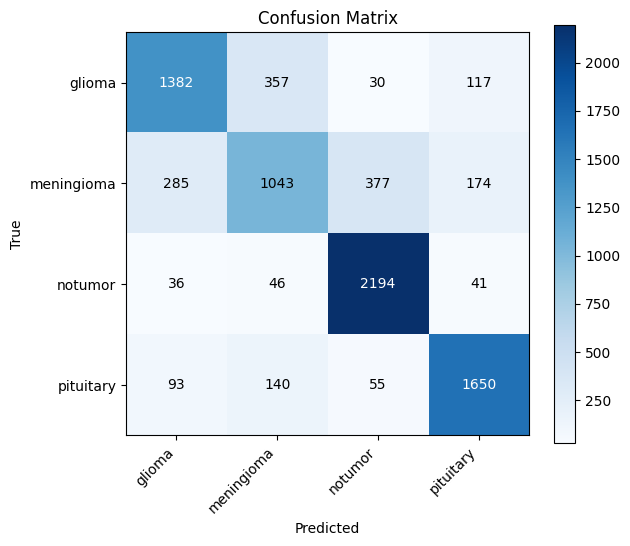

Saved: /kaggle/working/confusion_matrix.png


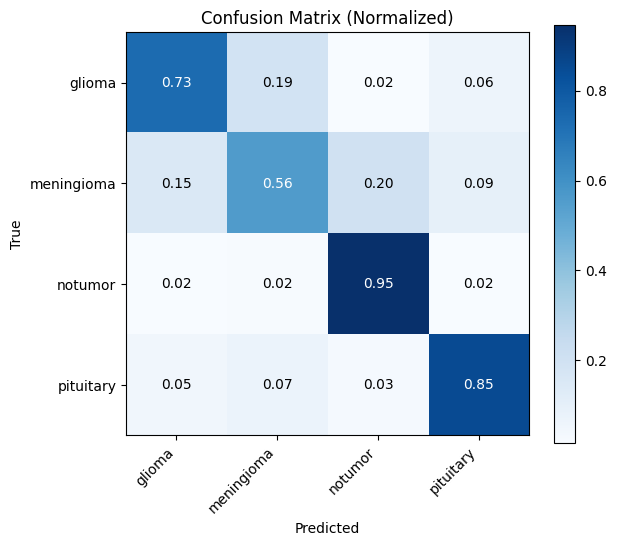

Saved: /kaggle/working/confusion_matrix_normalized.png

✅ All results saved to /kaggle/working/


In [7]:

final_model = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("pca", PCA(n_components=0.95, svd_solver="full", random_state=SEED)),
    ("svc", SVC(kernel="rbf", cache_size=2000,
                C=best_params["svc__C"], gamma=best_params["svc__gamma"],
                random_state=SEED))
])

t0 = time.time()
final_model.fit(X_train, y_train)
print(f"[fit on full train] done in {time.time()-t0:.1f}s")


def predict_in_batches(pipeline, X, batch_size=4000, show_progress=True):
    scaler = pipeline.named_steps["scaler"]
    pca    = pipeline.named_steps["pca"]
    svc    = pipeline.named_steps["svc"]
    preds = []
    n = X.shape[0]
    for s in range(0, n, batch_size):
        e = min(s+batch_size, n)
        Xt = scaler.transform(X[s:e])
        Xt = pca.transform(Xt)
        preds.append(svc.predict(Xt))
        if show_progress: print(f"predicted {e}/{n}", end="\r")
    print()
    return np.concatenate(preds)

y_pred = predict_in_batches(final_model, X_test, batch_size=4000)
acc = accuracy_score(y_test, y_pred)

print("\n Classification report:")
print(classification_report(y_test, y_pred, target_names=CLASSES, digits=4))
print(f" Test accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix (raw):")
print(cm)

def plot_cm(cm: np.ndarray, classes: list, normalize: bool, fname: str):
    M = cm.astype(np.float32)
    if normalize:
        s = M.sum(axis=1, keepdims=True)
        M = np.divide(M, s, out=np.zeros_like(M), where=s!=0)

    fig, ax = plt.subplots(figsize=(6.5,5.5))
    im = ax.imshow(M, interpolation='nearest', cmap='Blues')
    plt.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right'); ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    fmt = ".2f" if normalize else ".0f"
    thr = M.max()/2. if M.size else 0.5
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, format(M[i,j], fmt),
                    ha="center", va="center",
                    color="white" if M[i,j] > thr else "black")
    fig.tight_layout(); plt.show()
    fig.savefig(fname, dpi=200, bbox_inches="tight"); print("Saved:", fname)

plot_cm(cm, CLASSES, normalize=False, fname=str(WORK/"confusion_matrix.png"))
plot_cm(cm, CLASSES, normalize=True,  fname=str(WORK/"confusion_matrix_normalized.png"))


joblib.dump(final_model, WORK/"best_svm_model.joblib")
with open(WORK/"svm_results_summary.json","w",encoding="utf-8") as f:
    json.dump({"accuracy": float(acc),
               "classes": CLASSES,
               "best_params": best_params}, f, indent=2, ensure_ascii=False)
print("\n All results saved to /kaggle/working/")
